In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import NaN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import preprocessing

from sklearn import impute


In [367]:
def load_data(x_path):
    return pd.read_csv(x_path, low_memory=False)

In [521]:
x = load_data("train_x.csv")
y = load_data("train_y.csv")
mapping = dict(zip(y['patientunitstayid'], y['hospitaldischargestatus']))
x['hospitaldischargestatus'] = x['patientunitstayid'].map(mapping)

def extract_values(data, threshold):
    if(data.empty):
        return 0,0,0,0
    
    data['nursingchartvalue'] = data['nursingchartvalue'].astype(float) 
    data = data[data['nursingchartvalue'] < threshold] #remove outliers
    data = data.sort_values('offset')     #sort by offset to get first and last values recorded
    
    maxHeartData = data['nursingchartvalue'].max()
    minHeartData = data['nursingchartvalue'].min()
    firstHeartData = data['nursingchartvalue'].iloc[0]
    lastHeartData = data['nursingchartvalue'].iloc[-1]
    
    return maxHeartData, minHeartData, firstHeartData, lastHeartData

def add_columns(df, name, data):
    df[f'Max {name}'] = data[0]
    df[f'Min {name}'] = data[1]
    df[f'First {name}'] = data[2]
    df[f'Last {name}'] = data[3]
    
    return df

def correct_columns_div(df, name, size):
    df[f'Max {name}']  = df[f'Max {name}'] / size
    df[f'Min {name}'] = df[f'Min {name}'] / size
    df[f'First {name}'] = df[f'First {name}'] / size
    df[f'Last {name}'] = df[f'Last {name}'] / size
    
    return df

def clean_data(x, no_y = False):
    if no_y:
        predictors = ['age', 'admissionweight', 'gender', 'patientunitstayid', 'nursingchartcelltypevalname', 'nursingchartvalue', 'offset']
    else:
        predictors = ['age', 'admissionweight', 'gender', 'patientunitstayid', 'nursingchartcelltypevalname', 'nursingchartvalue', 'offset', 'hospitaldischargestatus']    

    x['gender'] = x['gender'].apply(lambda e: 1 if e == 'Female' else 0)
    x['age'] = x['age'].apply(lambda e: 90 if e == '> 89' else e)
    x['age'] = x['age'].apply(lambda e: int(e) if not e != e else e)
    x = x[predictors]

    unique_patients = x['patientunitstayid'].unique()
    num_patients = len(unique_patients)
    
    new_df = []
    for i in range(num_patients):
        pid = unique_patients[i]
        all_rows = x[x['patientunitstayid'] == pid]
        
        # Take the min and max heart rate
        heartData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Heart Rate'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxHeartData, minHeartData, firstHeartData, lastHeartData = extract_values(heartData, 300)

        # Take the min and max respiratory rate
        respData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Respiratory Rate'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxRespData, minRespData,firstRespData, lastRespData  = extract_values(respData, 1000)
        
        # Take the min and max Non-Invasive BP Systolic
        nibpsData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Non-Invasive BP Systolic'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxnibpsData, minnibpsData,firstnibpsData, lastnibpsData  = extract_values(nibpsData, 1000)
        
        # Take the min and max Non-Invasive BP Mean
        nibpmData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Non-Invasive BP Mean'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxnibpmData, minnibpmData,firstnibpmData, lastnibpmData  = extract_values(nibpmData, 1000)
        
        # Take the min and max Non-Invasive BP Diastolic
        nibpdData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Non-Invasive BP Diastolic'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxnibpdData, minnibpdData,firstnibpdData, lastnibpdData  = extract_values(nibpdData, 1000)
        
        # Remove certain columns
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Heart Rate']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Non-Invasive BP Systolic']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Non-Invasive BP Mean']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Non-Invasive BP Diastolic']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Respiratory Rate']        
        
        # Add new columns to all_row
        all_rows = add_columns(all_rows, "Heart Rate", [maxHeartData, minHeartData, firstHeartData, lastHeartData])
        all_rows = add_columns(all_rows, "Respiratory Rate", [maxRespData, minRespData,firstRespData, lastRespData])
        all_rows = add_columns(all_rows, "Non-Invasive BP Systolic", [maxnibpsData, minnibpsData,firstnibpsData, lastnibpsData])
        all_rows = add_columns(all_rows, "Non-Invasive BP Mean", [maxnibpsData, minnibpsData,firstnibpsData, lastnibpsData])
        all_rows = add_columns(all_rows, "Non-Invasive BP Diastolic", [maxnibpdData, minnibpdData,firstnibpdData, lastnibpdData])
        
        raw_rows = all_rows.groupby(['patientunitstayid']).sum(numeric_only=False)
        raw_rows = correct_columns_div(raw_rows, 'Heart Rate', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Respiratory Rate', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Non-Invasive BP Systolic', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Non-Invasive BP Mean', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Non-Invasive BP Diastolic', len(all_rows))

        new_df.append(raw_rows.squeeze())
    new_df = pd.DataFrame(new_df)
    
    return new_df

In [522]:
new_df = clean_data(x)
new_df = new_df.drop('hospitaldischargestatus', axis=1)
new_df = new_df.drop('nursingchartvalue', axis=1)
new_df = new_df.drop('nursingchartcelltypevalname', axis=1)
new_df = new_df.drop('offset', axis=1)

In [523]:
print(new_df.head(2))

           age  admissionweight  gender  Max Heart Rate  Min Heart Rate  \
141764.0  87.0              0.0     1.0           128.0            98.0   
141765.0  87.0             46.5     1.0           162.0            74.0   

          First Heart Rate  Last Heart Rate  Max Respiratory Rate  \
141764.0             128.0             98.0                   0.0   
141765.0              76.0            110.0                  36.0   

          Min Respiratory Rate  First Respiratory Rate  ...  \
141764.0                   0.0                     0.0  ...   
141765.0                  14.0                    20.0  ...   

          First Non-Invasive BP Systolic  Last Non-Invasive BP Systolic  \
141764.0                           176.0                          153.0   
141765.0                           172.0                          175.0   

          Max Non-Invasive BP Mean  Min Non-Invasive BP Mean  \
141764.0                     182.0                     153.0   
141765.0              

In [525]:
X = new_df[['age', 'admissionweight', 'gender', 
            'Max Heart Rate', 
            'Min Heart Rate', 
            'First Heart Rate', 
            'Last Heart Rate',
            
            'Max Respiratory Rate', 
            'Min Respiratory Rate', 
            'First Respiratory Rate', 
            'Last Respiratory Rate', 
            
            'Max Non-Invasive BP Systolic', 
            'Min Non-Invasive BP Systolic', 
            'First Non-Invasive BP Systolic', 
            'Last Non-Invasive BP Systolic', 
           
            'Max Non-Invasive BP Mean', 
            'Min Non-Invasive BP Mean', 
            'First Non-Invasive BP Mean', 
            'Last Non-Invasive BP Mean',
           
            'Max Non-Invasive BP Diastolic', 
            'Min Non-Invasive BP Diastolic', 
            'First Non-Invasive BP Diastolic', 
            'Last Non-Invasive BP Diastolic',]]
y = y = y[['hospitaldischargestatus']]

In [526]:
# plt.scatter(X[['age']].squeeze(), y.squeeze())

# plt.xlabel('age')
# plt.ylabel('hospitaldischargestatus')
# plt.show()

In [527]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [528]:
model = LogisticRegression(solver='lbfgs')
estimator = Pipeline([("imputer", impute.SimpleImputer(missing_values=np.nan, strategy="mean")),
                      ("scaler", preprocessing.StandardScaler()),
                      ("logistic_regression", model)])

In [529]:
estimator.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

In [530]:
y_pred = estimator.predict_proba(X_test)[:,1]
print('Accuracy of logistic regression classifier on the test set: {:.2f}'.format(estimator.score(X_test, y_test)))

Accuracy of logistic regression classifier on the test set: 0.92


In [531]:
logit_roc_auc = roc_auc_score(y_test.values.ravel(), estimator.predict_proba(X_test)[:,1 ])
print(logit_roc_auc)

#0.66643045803002

0.807318173033563


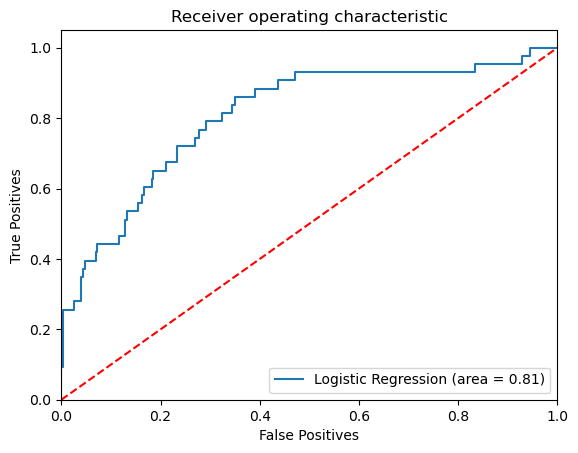

In [534]:
y_true_binary = np.zeros_like(y_test)
y_true_binary[y_test != 0] = 1
fpr, tpr, thresholds = roc_curve(y_true_binary, estimator.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [535]:
test_xdata = load_data("test_x.csv")
new_df2 = clean_data(test_xdata, True)
new_df2 = new_df2.drop('nursingchartvalue', axis=1)
new_df2 = new_df2.drop('nursingchartcelltypevalname', axis=1)
new_df2 = new_df2.drop('offset', axis=1)
print(new_df2.head(1))

y_pred2 = estimator.predict_proba(new_df2)[:,1]

           age  admissionweight  gender  Max Heart Rate  Min Heart Rate  \
151179.0  59.0              0.0     1.0           180.0            74.0   

          First Heart Rate  Last Heart Rate  Max Respiratory Rate  \
151179.0             112.0             97.0                  52.0   

          Min Respiratory Rate  First Respiratory Rate  ...  \
151179.0                  11.0                    30.0  ...   

          First Non-Invasive BP Systolic  Last Non-Invasive BP Systolic  \
151179.0                            60.0                           79.0   

          Max Non-Invasive BP Mean  Min Non-Invasive BP Mean  \
151179.0                     134.0                      40.0   

          First Non-Invasive BP Mean  Last Non-Invasive BP Mean  \
151179.0                        60.0                       79.0   

          Max Non-Invasive BP Diastolic  Min Non-Invasive BP Diastolic  \
151179.0                           74.0                           20.0   

          First Non

In [536]:
def save_to_csv(prediction_probs, y):
    f = open("foo.csv", "w")
    f.write("patientunitstayid,hospitaldischargestatus" + "\n")

    for i,j in zip(y.index.values, prediction_probs):
        f.write(str(int(i)) + "," + str(j) + "\n")
    f.close()

In [537]:
save_to_csv(y_pred2, new_df2)